# IRAM Data Example

Trey V. Wenger (c) December 2024

Here we demonstrate `HFSAnomalyIRAMModel` and `CNRatioAnomalyIRAMModel` on some real IRAM 30-m data.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+0.g50000b9.dirty


## Load the data

dict_keys(['12CN-1/2', '12CN-3/2'])


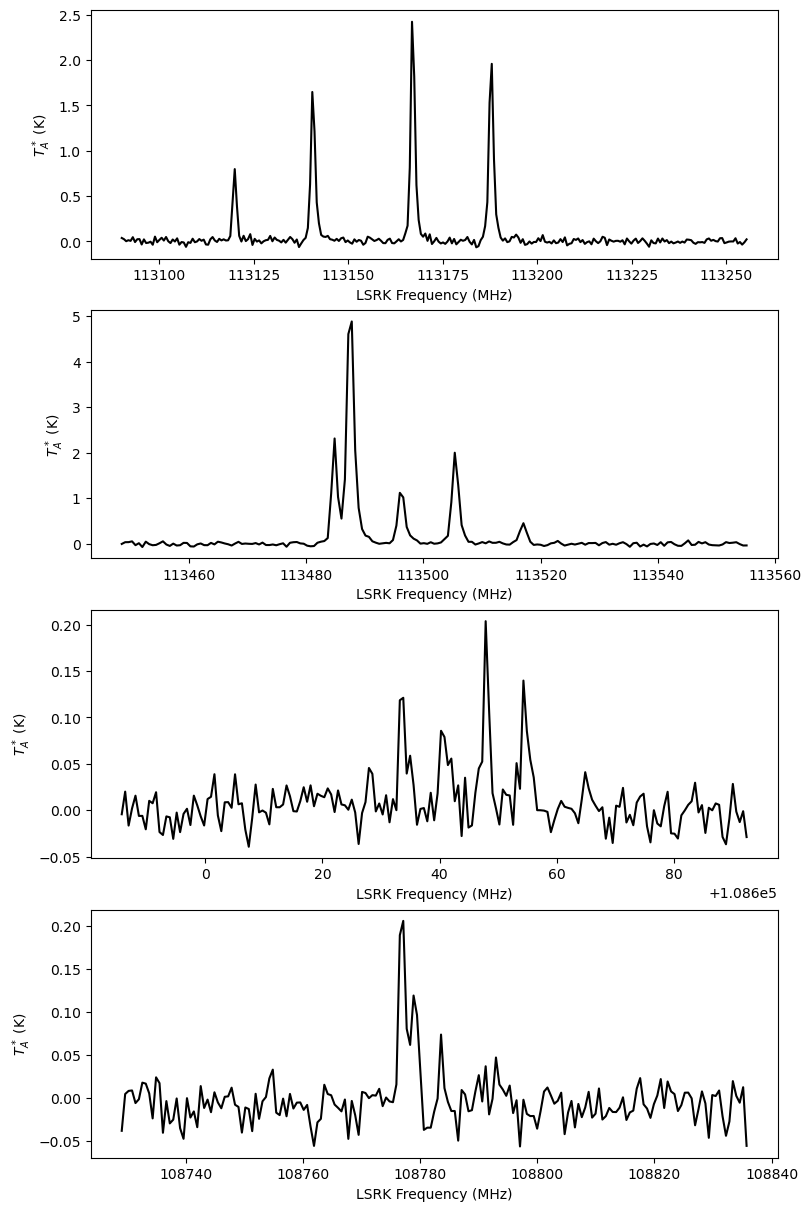

In [2]:
from bayes_spec import SpecData
import pickle

with open("iram_data.pkl", "rb") as f:
    iram_data = pickle.load(f)

labels = ["12CN-1/2", "12CN-3/2", "13CN-1/2", "13CN-3/2"]
data = {
    label: SpecData(
        iram_data[f"frequency_{label}"],
        iram_data[f"spectrum_{label}"],
        iram_data[f"rms_{label}"],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_A^*$ (K)",
    )
    for label in labels
}
data_12CN = {
    label: SpecData(
        iram_data[f"frequency_{label}"],
        iram_data[f"spectrum_{label}"],
        iram_data[f"rms_{label}"],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_A^*$ (K)",
    )
    for label in labels if "12CN" in label
}
print(data_12CN.keys())

# Plot the data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, label in enumerate(labels):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Determine Number of Clouds

In [3]:
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

In [4]:
from bayes_cn_hfs import HFSAnomalyIRAMModel
from bayes_spec import Optimize

max_n_clouds = 5
baseline_degree = 0
opt = Optimize(
    HFSAnomalyIRAMModel,
    data_12CN,
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    mol_data=mol_data_12CN,
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True,
)
opt.add_priors(
    prior_log10_N = [14.0, 0.5], # mean and width of log10(N_u) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_fwhm = 2.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_log10_tex_anomaly = 0.1, # width of the Tex anomaly prior (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Dropping the un-observed transitions at the following frequencies (MHz):
[]
Dropping the un-observed transitions at the following frequencies (MHz):
[]
Dropping the un-observed transitions at the following frequencies (MHz):
[]
Dropping the un-observed transitions at the following frequencies (MHz):
[]
Dropping the un-observed transitions at the following frequencies (MHz):
[]


In [5]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
opt.fit_all(**fit_kwargs)

Null hypothesis BIC = 5.591e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 8,908.3


Output()

n_cloud = 1 BIC = -6.469e+02

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 6000
Interrupted at 5,999 [5%]: Average Loss = 4,806


Output()

n_cloud = 2 BIC = -1.406e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 6200
Interrupted at 6,199 [6%]: Average Loss = 4,656.4


Output()

n_cloud = 3 BIC = -1.490e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 5900
Interrupted at 5,899 [5%]: Average Loss = 5,131.9


Output()

n_cloud = 4 BIC = -1.485e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 5700
Interrupted at 5,699 [5%]: Average Loss = 5,415


Output()

n_cloud = 5 BIC = -1.441e+03



In [6]:
n_clouds = np.arange(max_n_clouds + 1)
null_bic = opt.models[1].null_bic()
bics = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
for n_cloud, bic in zip(n_clouds, bics):
    print(n_cloud, bic)

0 55908.20168251624
1 -646.8766827803033
2 -1406.1154465973782
3 -1489.9598878743059
4 -1485.3046539258999
5 -1441.0439844848936


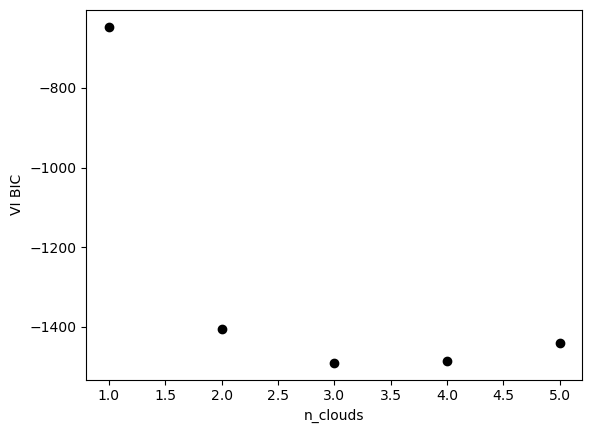

In [7]:
fig, ax = plt.subplots()
ax.plot(n_clouds[1:], bics[1:], 'ko')
ax.set_xlabel("n_clouds")
_ = ax.set_ylabel("VI BIC")

The model with `n_clouds = 3` seems to be best. Note that VI might not give the best results.

## MCMC

In [8]:
from bayes_cn_hfs import CNRatioAnomalyIRAMModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = CNRatioAnomalyIRAMModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 1.0], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [10.0, 10.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_log10_tex_12CN_anomaly = 0.1, # width of 12CN Tex anomaly (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Dropping the un-observed 12CN transitions at the following frequencies (MHz):
[]
Dropping the un-observed 13CN transitions at the following frequencies (MHz):
[108056.1506 108057.1294 108062.9185 108076.9565 108077.2715 108091.3095
 108406.0979 108412.862  108426.889  108986.8678 109217.6017 109218.3621
 109218.9506]


Sampling: [12CN-1/2, 12CN-3/2, 13CN-1/2, 13CN-3/2, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, baseline_13CN-1/2_norm, baseline_13CN-3/2_norm, fwhm_norm, log10_N_12CN_norm, log10_tex_12CN_comp_norm, log10_tex_norm, ratio_13C_12C_norm, velocity_norm]


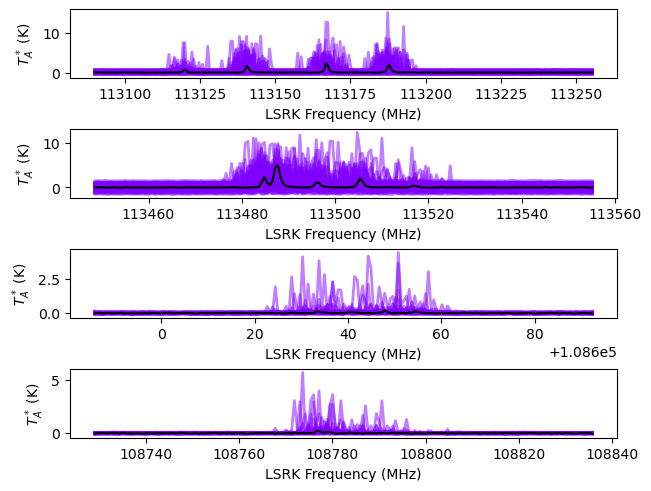

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [10]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6400
Interrupted at 6,399 [6%]: Average Loss = 4,377.1
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, baseline_13CN-1/2_norm, baseline_13CN-3/2_norm, log10_N_12CN_norm, log10_tex_norm, fwhm_norm, velocity_norm, ratio_13C_12C_norm, log10_tex_12CN_comp_norm]


Output()

Sampling 8 chains for 1_000 tune and 5 draw iterations (8_000 + 40 draws total) took 8581 seconds.
/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (8) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Adding log-likelihood to trace


Output()

Runtime: 145.10 minutes


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (8) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
